# Crime Dataset Analysis with Crime Rate Forcasting & Crime Type Prediction
> Toronto Public Service Public Safety Data [MCI 2014 to 2019]

* The Major Crime Indicators categories are Assault, Break and Enter,  Auto Theft, Robbery and Theft Over (Excludes Sexual Assaults). 
* The reported crime dataset is intended to provide communities with information regarding public safety and awareness. The data supplied to the Toronto Police Service by the reporting parties is preliminary and may not have been fully verified.
* In accordance with the Municipal Freedom of Information and Protection of Privacy Act, the Toronto Police Service has taken the necessary measures to protect the privacy of individuals involved in the reported occurrences. No personal information related to any of the parties involved in the occurrence will be released as open data.
* The location of crime occurrences have been deliberately offset to the nearest road intersection node to protect the privacy of parties involved in the occurrence. All location data must be considered as an approximate location of the occurrence and users are advised not to interpret any of these locations as related to a specific address or individual.

#### Data License
> [Open Government License Ontario](https://www.ontario.ca/page/open-government-licence-ontario)

#### Data Source
> [Data Source Service](https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/MCI_2014_to_2019/FeatureServer/0)

#### Code License
> [GNU GPLv3 License](https://www.gnu.org/licenses/gpl-3.0.en.html)

## Library Import & Parameter Fixes

In [ ]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.api as sm
from sklearn.metrics import r2_score
from fbprophet import Prophet

from sklearn.ensemble import RandomForestClassifier

In [ ]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = (30,6)
matplotlib.rcParams['axes.titlesize']= 20

In [ ]:
def mapperDictGenerator(df, label):
  d= dict()
  factorized= pd.factorize(df[label])
  for i, _ in enumerate(factorized[1]):
    d[i]= _
  return factorized[0], d

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Arpan/Copy of MCI_2014_to_2019.csv')
df.head()

X          Y  Index_  ...       Long        Lat ObjectId
0 -79.405228  43.656982    7801  ... -79.405228  43.656982     7001
1 -79.307907  43.778732    7802  ... -79.307907  43.778732     7002
2 -79.225029  43.765942    7803  ... -79.225029  43.765942     7003
3 -79.140823  43.778648    7804  ... -79.140823  43.778648     7004
4 -79.288361  43.691235    7805  ... -79.288361  43.691235     7005

[5 rows x 29 columns]

## Analysis and **Plotting** of Different Crime Types

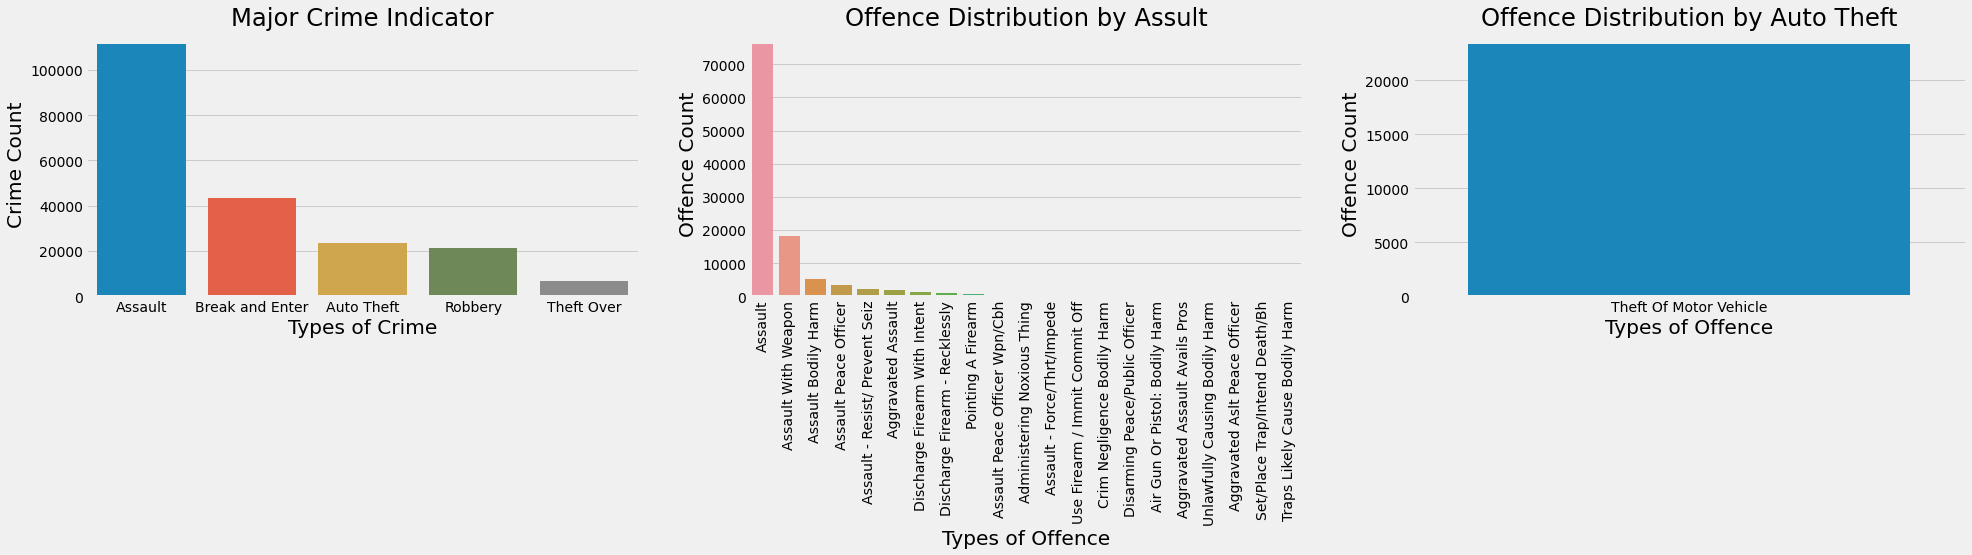

In [ ]:
plt.figure(figsize=(30,10))
MCI= df.groupby('MCI',as_index=False).size()
assaultTypes= df[df.MCI=='Assault'].groupby('offence', as_index=False).size()
autoTheftTypes= df[df.MCI=='Auto Theft'].groupby('offence', as_index=False).size()

plt.subplot(231)
sns.barplot(x='MCI', y='size', data=MCI.sort_values(by='size', ascending=False))
plt.title('Major Crime Indicator', fontsize='xx-large')
plt.xlabel('Types of Crime', fontsize='x-large')
plt.ylabel('Crime Count', fontsize='x-large')

plt.subplot(232)
sns.barplot(x='offence', y='size', data=assaultTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Assult', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(233)
sns.barplot(x='offence', y='size', data=autoTheftTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Auto Theft', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')

plt.show()

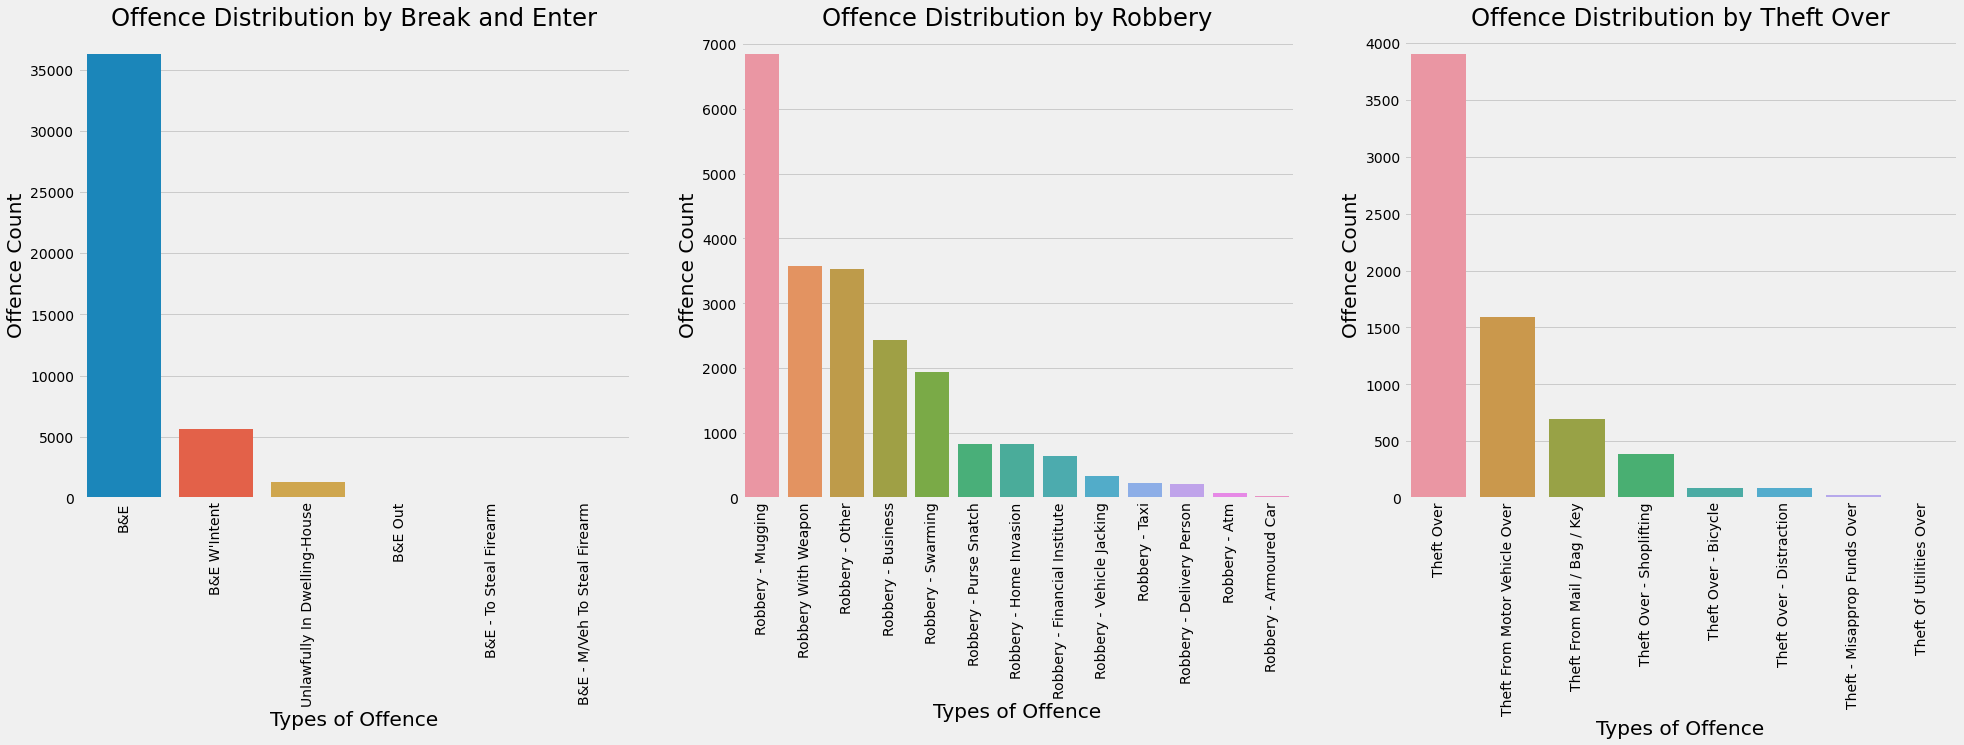

In [ ]:
plt.figure(figsize=(30,8))

breakEnterTypes= df[df.MCI=='Break and Enter'].groupby('offence', as_index=False).size()
robberyTypes= df[df.MCI=='Robbery'].groupby('offence', as_index=False).size()
theftOverTypes= df[df.MCI=='Theft Over'].groupby('offence', as_index=False).size()

plt.subplot(131)
sns.barplot(x='offence', y='size', data=breakEnterTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Break and Enter', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(132)
sns.barplot(x='offence', y='size', data=robberyTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Robbery', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(133)
sns.barplot(x='offence', y='size', data=theftOverTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Theft Over', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.show()

In [ ]:
df.reporteddate= pd.to_datetime(df.reporteddate)
df['reportOnlyDate']= df.reporteddate.dt.date
df.occurrencedate= pd.to_datetime(df.occurrencedate)
df['occurrenceOnlyDate']= df.occurrencedate.dt.date
df['delayInReporting']= (df.reportOnlyDate - df.occurrenceOnlyDate).dt.days

# **Time Series Forcasting** Problem and Multipath Approach

## Time Series Analysis for **Total Crime Count**

In [ ]:
df['count']= 1
mci_monthwise = df.groupby(['occurrenceday','MCI'],as_index=False).agg({'count':'sum'})

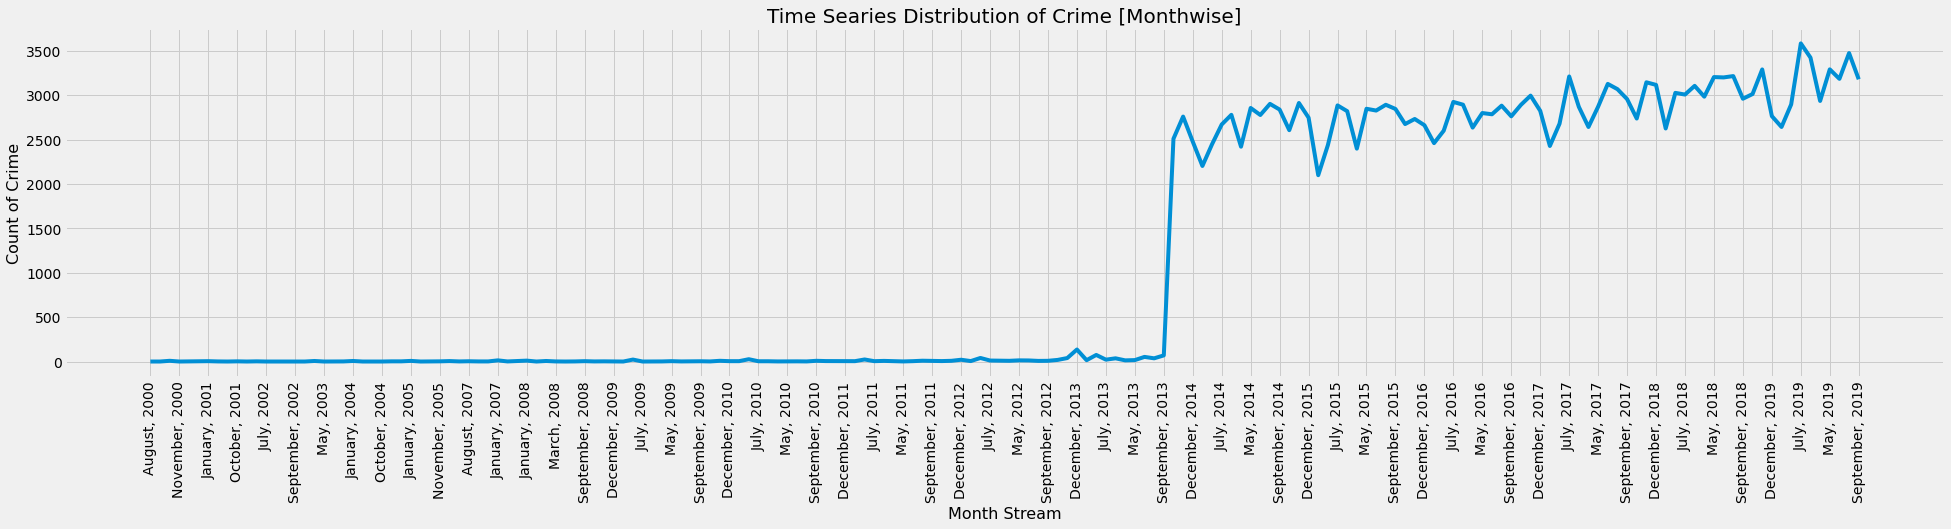

In [ ]:
mci_distribution = df.groupby(['occurrenceyear','occurrencemonth'],as_index=False).agg({'count':'sum'})
mci_distribution['occurrenceyear']= mci_distribution['occurrenceyear'].astype('int').astype('str')
mci_distribution['monthYear']= mci_distribution['occurrencemonth'] +', '+ mci_distribution['occurrenceyear']

plt.grid('on')
plt.plot(mci_distribution['monthYear'], mci_distribution['count'])
plt.xlabel('Month Stream')
plt.ylabel('Count of Crime')
plt.title('Time Searies Distribution of Crime [Monthwise]')
plt.xticks(np.arange(0, mci_distribution['monthYear'].shape[0], 3), rotation=90)
plt.show()

In [ ]:
occuranceDateVsMciCount= df.groupby(['occurrenceOnlyDate','MCI'],as_index=False).agg({'count':'sum'})
trimmedOccuranceDateVsMciCount= occuranceDateVsMciCount[occuranceDateVsMciCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]

In [ ]:
# occuranceDateCount= df.groupby(['occurrenceOnlyDate'],as_index=False).agg({'count':'sum'})
occuranceDateCount= df.groupby('occurrenceOnlyDate')['count'].sum().reset_index()
trimmedOccuranceDateCount= occuranceDateCount[occuranceDateCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]
trimmedOccuranceDateCount['occurrenceOnlyDate']= pd.to_datetime(trimmedOccuranceDateCount.occurrenceOnlyDate)
trimmedOccuranceDateCount.set_index('occurrenceOnlyDate', inplace=True)

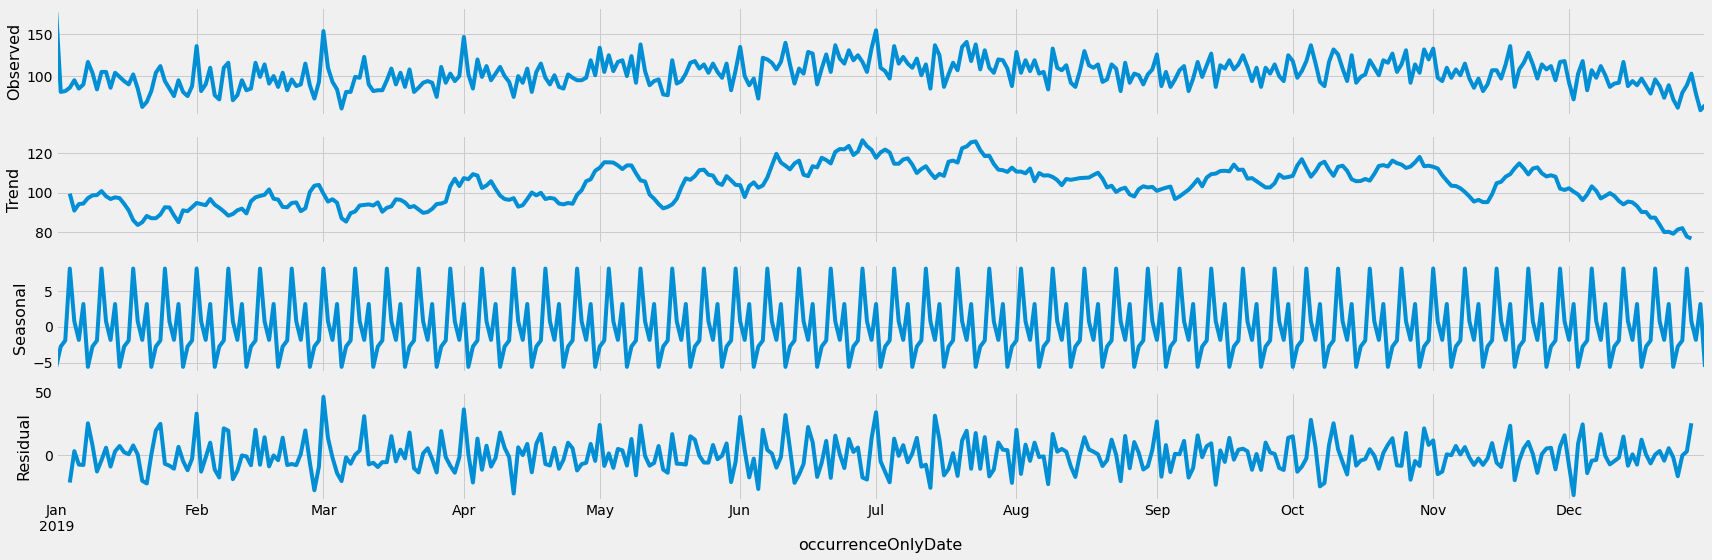

In [ ]:
decomposition= sm.tsa.seasonal_decompose(trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')], model='additive')

plt.rcParams['figure.figsize'] = 24, 8
decomposition.plot()

plt.show()

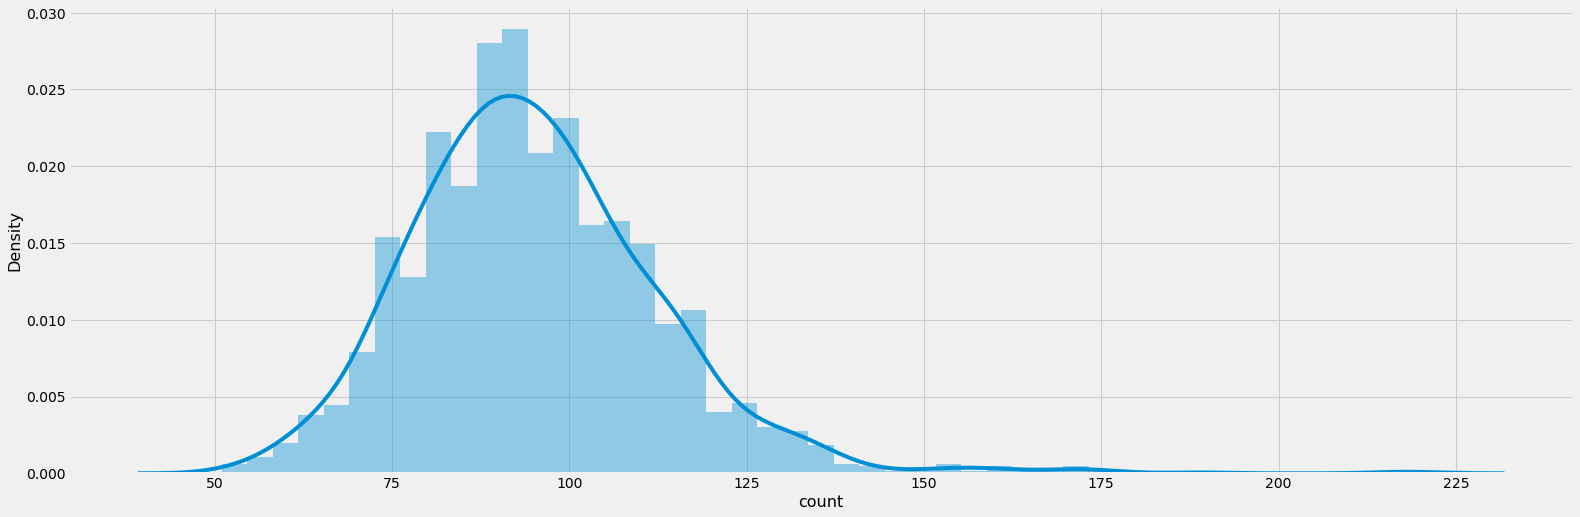

In [ ]:
sns.distplot(trimmedOccuranceDateCount['count'])
plt.show()

In [ ]:
trainData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index < pd.to_datetime('2018-12-31')]
testData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')]

In [ ]:
y= trimmedOccuranceDateCount['count'].resample('MS').mean()

## **ARIMA** Time Series Forcasting

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
resultDict= dict()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod= sm.tsa.statespace.SARIMAX(trainData, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results= mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            resultDict['ARIMA{}x{}12'.format(param, param_seasonal)]= results.aic
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:17416.56741969255
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15834.289307207722
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13080.942401398417
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:12173.566337827879
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13114.613248496138
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:12239.617844055278
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:12664.253674635018
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12173.585890976676
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:15918.05394188398
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14988.462581171843
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13056.04538202997
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:12125.886753981604
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:13093.041693103562
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12192.606354550739
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:12637.874129756861
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:12126.976975665619
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:12997.18729335237
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:12902.778113604

In [ ]:
minIndexARIMA= list(resultDict.keys())[(list(resultDict.values()).index(min(resultDict.values())))]
print('MIN INDEX: {}'.format(minIndexARIMA))

MIN INDEX: ARIMA(1, 1, 1)x(0, 1, 1, 12)12


In [ ]:
SARIMAXmodel= sm.tsa.statespace.SARIMAX(trainData, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
SARIMAXresults= SARIMAXmodel.fit()
print(SARIMAXresults.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0994      0.025      3.964      0.000       0.050       0.149
ma.L1         -1.0365      0.008   -136.455      0.000      -1.051      -1.022
ma.S.L12      -1.0000     33.167     -0.030      0.976     -66.006      64.006
sigma2       234.1510   7766.279      0.030      0.976    -1.5e+04    1.55e+04


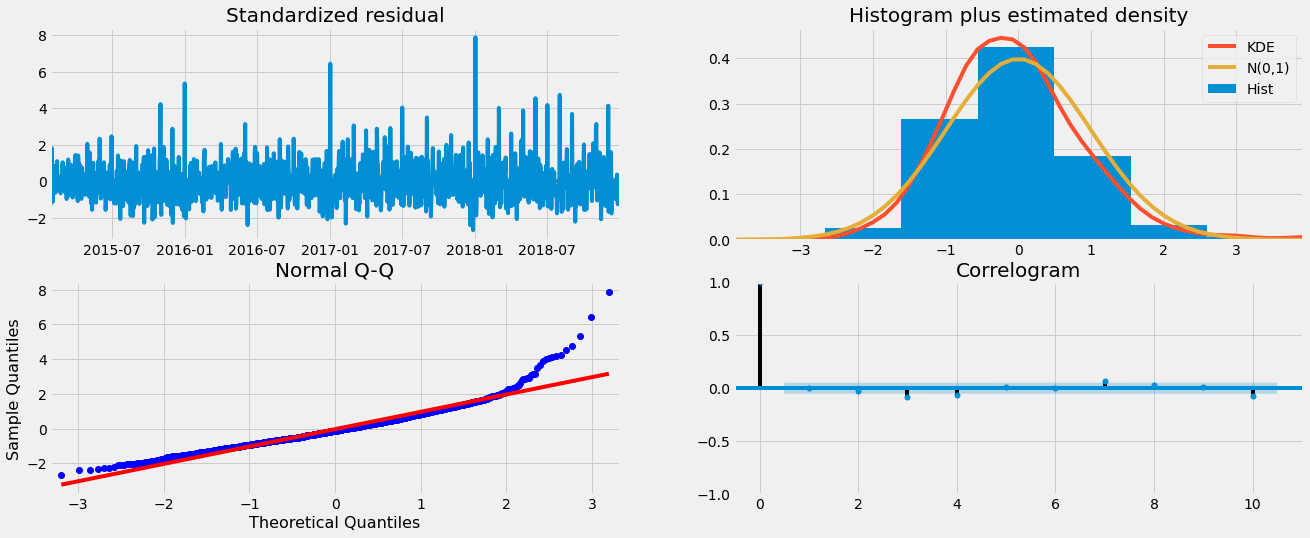

In [ ]:
SARIMAXresults.plot_diagnostics(figsize=(20, 8))
plt.show()

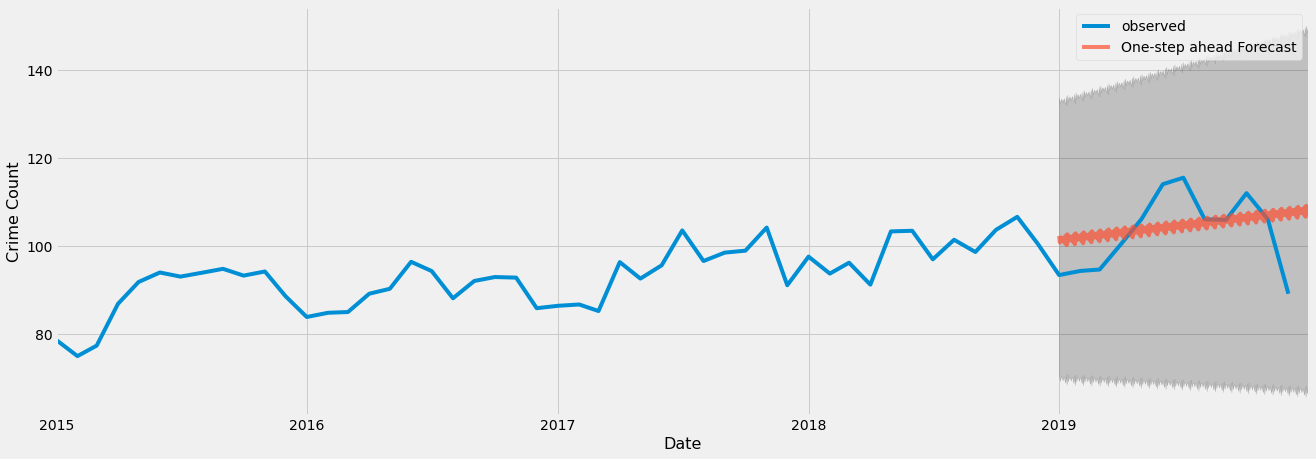

In [ ]:
SARIMAXpred= SARIMAXresults.get_prediction(start=testData.index.min(), end=testData.index.max(), dynamic=False)
SARIMAXpred_ci= SARIMAXpred.conf_int()
ax= y.plot(label='observed')
SARIMAXpred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 7))
ax.fill_between(SARIMAXpred_ci.index, SARIMAXpred_ci.iloc[:, 0], SARIMAXpred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
plt.legend()

plt.show()

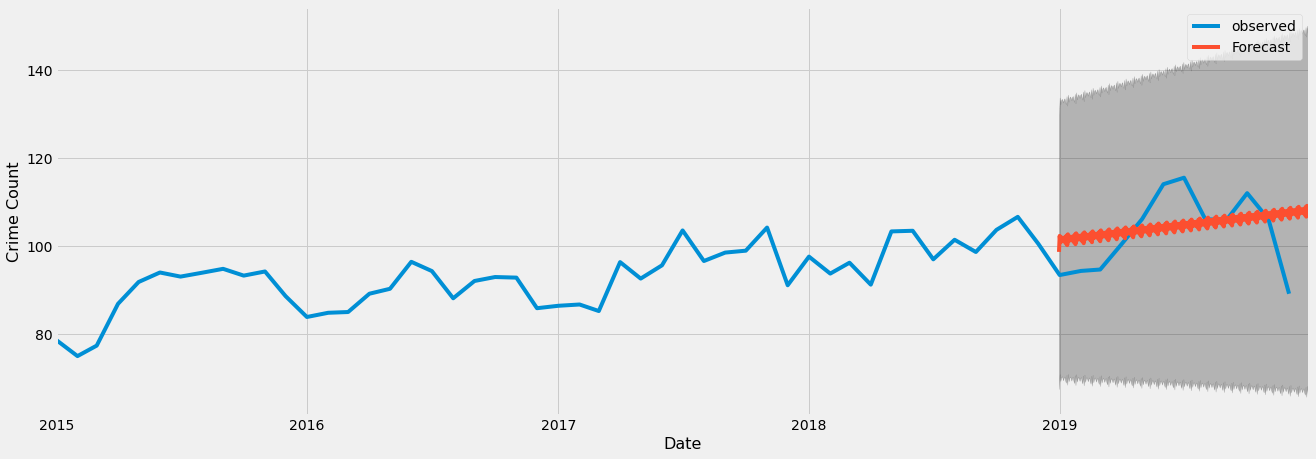

In [ ]:
pred_uc= SARIMAXresults.get_forecast(steps=365)
pred_ci= pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(20, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
plt.legend()
plt.show()

In [ ]:
testData['predValues']= SARIMAXpred.predicted_mean.astype('int')

testData['lowerCount']= pred_ci[pred_ci.index >= testData.index.min()]['lower count']
testData['upperCount']= pred_ci[pred_ci.index >= testData.index.min()]['upper count']

mse= round(((testData['count'] - testData['predValues'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((testData['upperCount'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((testData['lowerCount'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(testData.head())

Mean Square Error: 290.11
Root Mean Square Error: 17.03
Mean Square Error with Upper Envelop: 1707.73
Root Mean Square Error with Upper Envelop: 41.32
Mean Square Error with Lower Envelop: 1503.55
Root Mean Square Error with Lower Envelop: 38.78

                    count  predValues  lowerCount  upperCount
occurrenceOnlyDate                                           
2019-01-01            177         102   70.838783  133.831624
2019-01-02             81         100   69.308981  132.374860
2019-01-03             82         101   70.064415  133.179834
2019-01-04             86         101   70.381296  133.544138
2019-01-05             95         101   70.029399  133.238222


## **Prophet** Time Series

In [ ]:
trimmedOccuranceDateCountProphetFit= trainData.reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
prophet_model= Prophet(daily_seasonality=True)
prophet_model.fit(trimmedOccuranceDateCountProphetFit)

In [ ]:
prophetForecast= prophet_model.make_future_dataframe(periods=365)
prophetForecast= prophet_model.predict(prophetForecast)

<Figure size 1296x432 with 0 Axes>

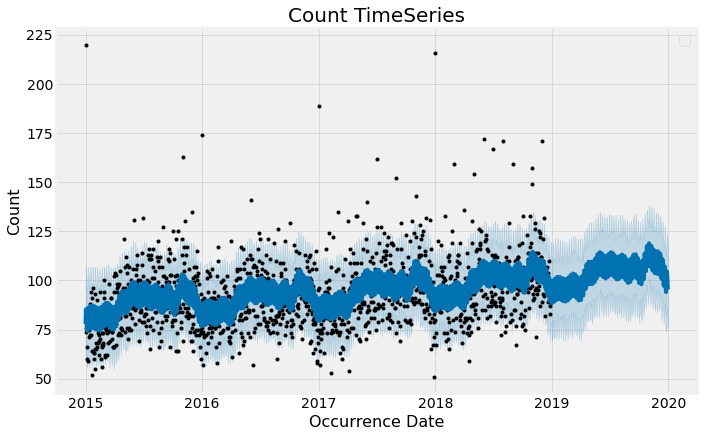

In [ ]:
plt.figure(figsize=(18, 6))
prophet_model.plot(prophetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.legend()
plt.title('Count TimeSeries');

## **Model Comparison** and Actual Value Deviation Analysis

In [ ]:
prophetForcast_yhat= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
prophetForcast_trend= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['trend', 'trend_lower', 'trend_upper']]
for _ in tqdm(prophetForcast_yhat.columns):
  prophetForcast_yhat[_]= prophetForcast_yhat[_].astype('int')
for _ in tqdm(prophetForcast_trend.columns):
  prophetForcast_trend[_]= prophetForcast_trend[_].astype('int')

100%|██████████| 3/3 [00:00<00:00, 546.11it/s]


In [ ]:
mse= round(((testData['count'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Complete yHat Data Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(prophetForcast_yhat.head())

Prophet Complete yHat Data Error Analysis

Mean Square Error: 248.27
Root Mean Square Error: 15.76
Mean Square Error with Upper Envelop: 620.74
Root Mean Square Error with Upper Envelop: 24.91
Mean Square Error with Lower Envelop: 658.3
Root Mean Square Error with Lower Envelop: 25.66

            yhat  yhat_lower  yhat_upper
ds                                      
2019-01-01    88          69         108
2019-01-02    91          71         110
2019-01-03    92          72         110
2019-01-04    99          79         119
2019-01-05    98          76         118


In [ ]:
mse= round(((testData['count'] - prophetForcast_trend['trend'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_trend['trend_upper'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_trend['trend_lower'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Complete Trend Data Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(prophetForcast_trend.head())

Prophet Complete Trend Data Error Analysis

Mean Square Error: 11512.25
Root Mean Square Error: 107.3
Mean Square Error with Upper Envelop: 11553.22
Root Mean Square Error with Upper Envelop: 107.49
Mean Square Error with Lower Envelop: 11485.1
Root Mean Square Error with Lower Envelop: 107.17

            trend  trend_lower  trend_upper
ds                                         
2019-01-01    207          207          207
2019-01-02    207          207          207
2019-01-03    207          207          207
2019-01-04    207          207          207
2019-01-05    207          207          207


In [ ]:
mse= round(((testData['predValues'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['upperCount'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['lowerCount'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))

Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis

Mean Square Error: 34.76
Root Mean Square Error: 5.9
Mean Square Error with Upper Envelop: 367.03
Root Mean Square Error with Upper Envelop: 19.16
Mean Square Error with Lower Envelop: 264.35
Root Mean Square Error with Lower Envelop: 16.26


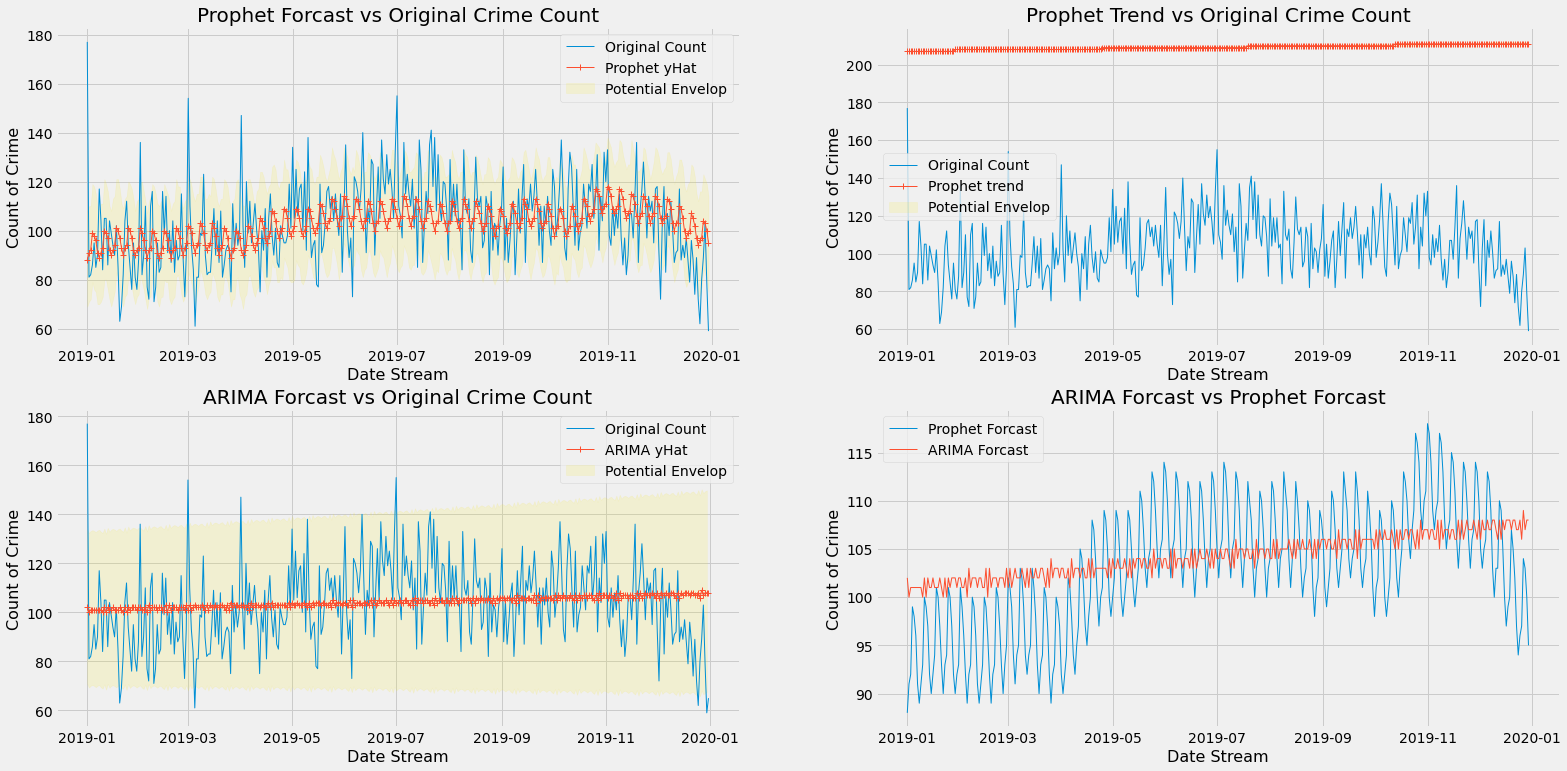

In [ ]:
plt.rcParams['figure.figsize']= 24, 12

plt.subplot(221)
plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count')
plt.plot(prophetForcast_yhat.index, testData['count'].iloc[:-1], lw=1)
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1, marker='+')
plt.fill_between(prophetForcast_yhat.index, prophetForcast_yhat['yhat_upper'], prophetForcast_yhat['yhat_lower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])

plt.subplot(222)
plt.grid('on')
plt.title('Prophet Trend vs Original Crime Count')
plt.plot(prophetForcast_trend.index, testData['count'].iloc[:-1], lw=1)
plt.plot(prophetForcast_trend.index, prophetForcast_trend['trend'], lw=1, marker='+')
plt.fill_between(prophetForcast_trend.index, prophetForcast_trend['trend_upper'], prophetForcast_trend['trend_lower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet trend', 'Potential Envelop'])

plt.subplot(223)
plt.grid('on')
plt.title('ARIMA Forcast vs Original Crime Count')
plt.plot(testData.index, testData['count'], lw=1)
plt.plot(testData.index, testData['predValues'], lw=1, marker='+')
plt.fill_between(testData.index, testData['upperCount'], testData['lowerCount'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'ARIMA yHat', 'Potential Envelop'])

plt.subplot(224)
plt.grid('on')
plt.title('ARIMA Forcast vs Prophet Forcast')
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1)
plt.plot(testData.index[:-1], testData['predValues'][:-1], lw=1)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Prophet Forcast', 'ARIMA Forcast'])

plt.show()

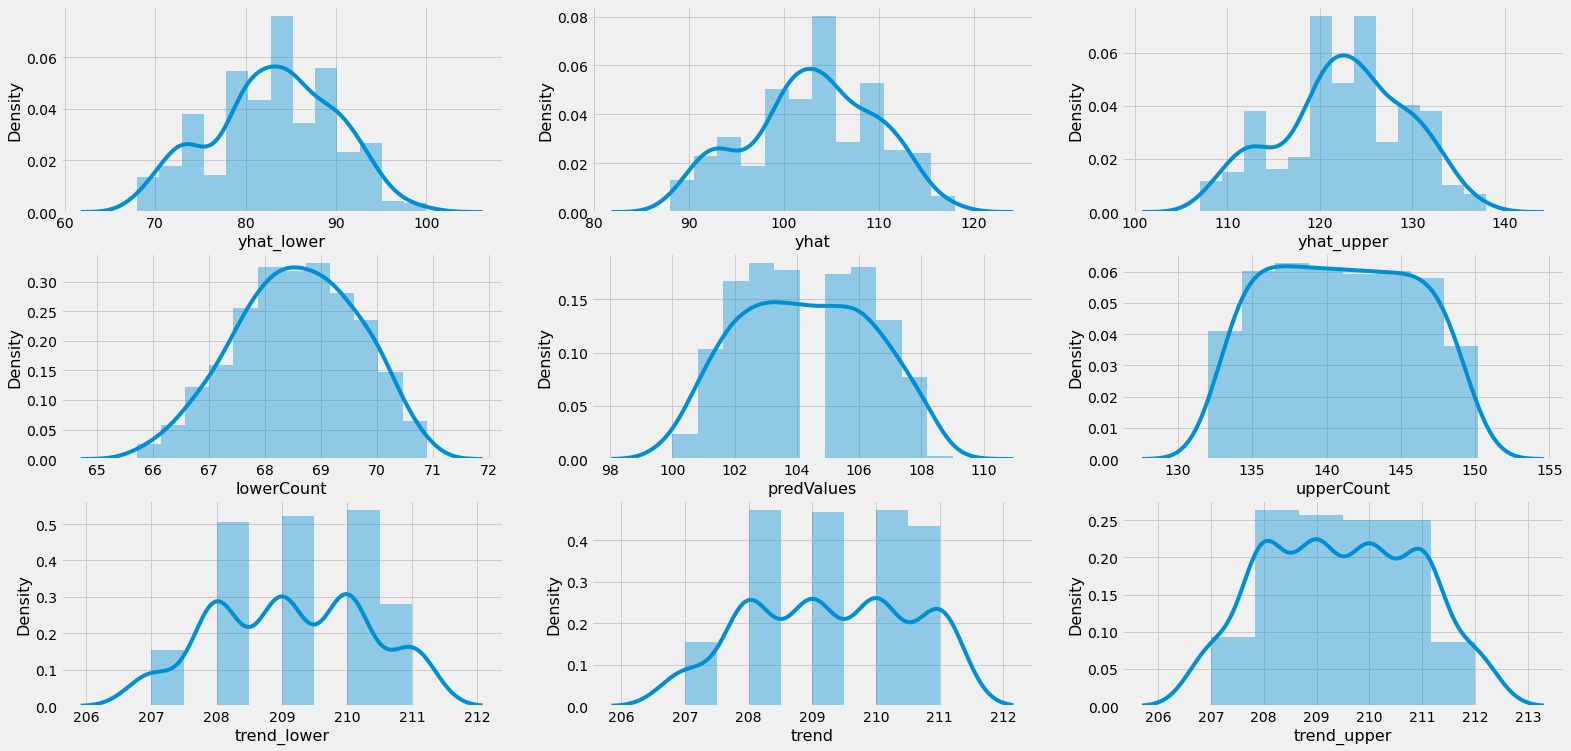

In [ ]:
plt.subplot(331)
sns.distplot(prophetForcast_yhat['yhat_lower'])

plt.subplot(332)
sns.distplot(prophetForcast_yhat['yhat'])

plt.subplot(333)
sns.distplot(prophetForcast_yhat['yhat_upper'])

plt.subplot(334)
sns.distplot(testData['lowerCount'])

plt.subplot(335)
sns.distplot(testData['predValues'])

plt.subplot(336)
sns.distplot(testData['upperCount'])

plt.subplot(337)
sns.distplot(prophetForcast_trend['trend_lower'])

plt.subplot(338)
sns.distplot(prophetForcast_trend['trend'])

plt.subplot(339)
sns.distplot(prophetForcast_trend['trend_upper'])


plt.show()

## **MCI Oriented** Time Series Forcasting of Data

In [ ]:
print('Different Major Crime Indicators', end='\n\n')
for i, _ in enumerate(np.unique(df.MCI)):
  print('{}. {}'.format(i, _))

Different Major Crime Indicators

0. Assault
1. Auto Theft
2. Break and Enter
3. Robbery
4. Theft Over


In [ ]:
mciDifferedResult= pd.DataFrame()

### Assault
> Major MCI **Assault** Data Extraction

In [ ]:
assaultTimewiseData= df[df.MCI == 'Assault'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
assaultTimewiseData= assaultTimewiseData[assaultTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  assaultTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

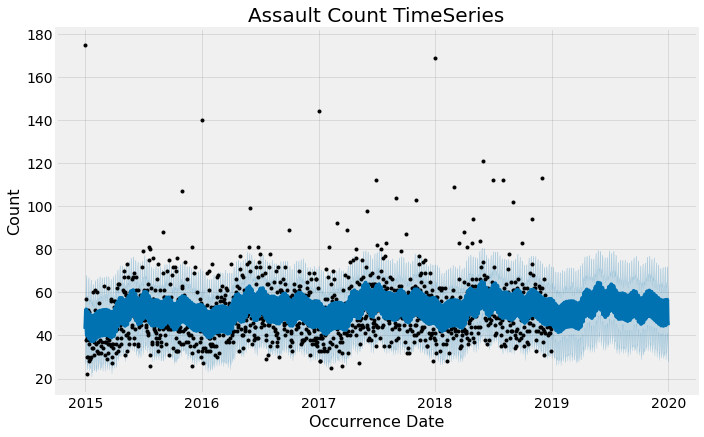

In [ ]:
assaultProphetModel= Prophet(daily_seasonality=True).fit(assaultTimewiseData[assaultTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
assaultProphetForecast= assaultProphetModel.make_future_dataframe(periods=365)
assaultProphetForecast= assaultProphetModel.predict(assaultProphetForecast)

assaultProphetModel.plot(assaultProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Assault Count TimeSeries');

In [ ]:
comparableData= assaultTimewiseData[assaultTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= assaultProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= assaultProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= assaultProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['Assault']= comparableData.yhat
mciDifferedResult['lower']= comparableData.yhatLower
mciDifferedResult['upper']= comparableData.yhatUpper

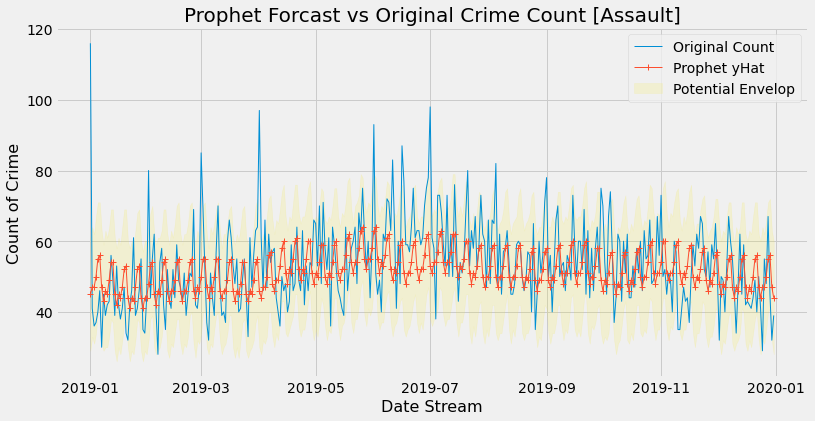

In [ ]:
# assaultProphetForecast['yhat']= assaultProphetForecast['yhat'].astype('int')
# assaultProphetForecast['ds']= pd.to_datetime(assaultProphetForecast['ds']).dt.date
# assaultProphetForecast[assaultProphetForecast.ds >= pd.to_datetime('2019-01-01').date()]
plt.rcParams['figure.figsize']= 12,6

plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

### Auto Theft
> Major MCI **Auto Theft** Data Extraction

In [ ]:
autoTheftTimewiseData= df[df.MCI == 'Auto Theft'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
autoTheftTimewiseData= autoTheftTimewiseData[autoTheftTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  autoTheftTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

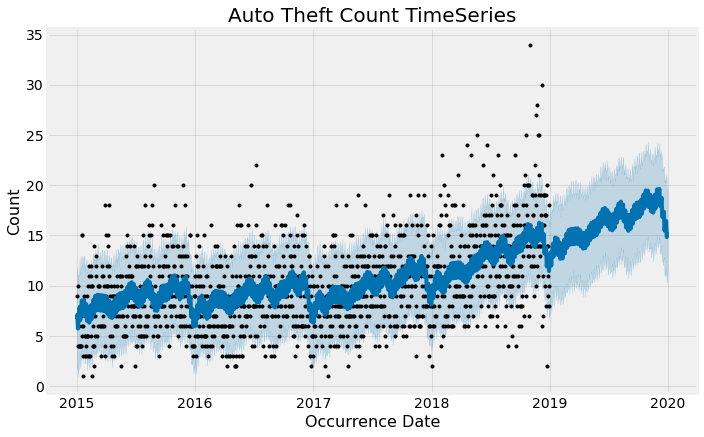

In [ ]:
autoTheftProphetModel= Prophet(daily_seasonality=True).fit(autoTheftTimewiseData[autoTheftTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
autoTheftProphetForecast= autoTheftProphetModel.make_future_dataframe(periods=365)
autoTheftProphetForecast= autoTheftProphetModel.predict(autoTheftProphetForecast)


autoTheftProphetModel.plot(autoTheftProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Auto Theft Count TimeSeries');

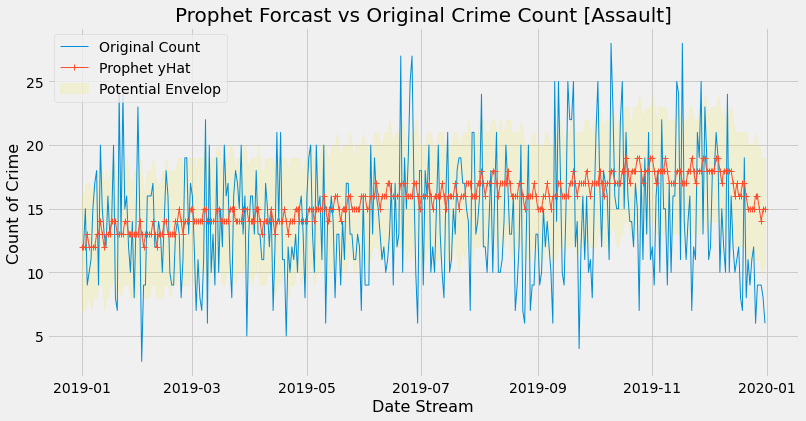

In [ ]:
comparableData= autoTheftTimewiseData[autoTheftTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= autoTheftProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= autoTheftProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= autoTheftProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['AutoTheft']= comparableData.yhat
mciDifferedResult['lower']= mciDifferedResult['lower'] + comparableData.yhatLower
mciDifferedResult['upper']= mciDifferedResult['upper'] + comparableData.yhatUpper


plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

### Break and Enter
> Major MCI **Break and Enter** Data Extraction

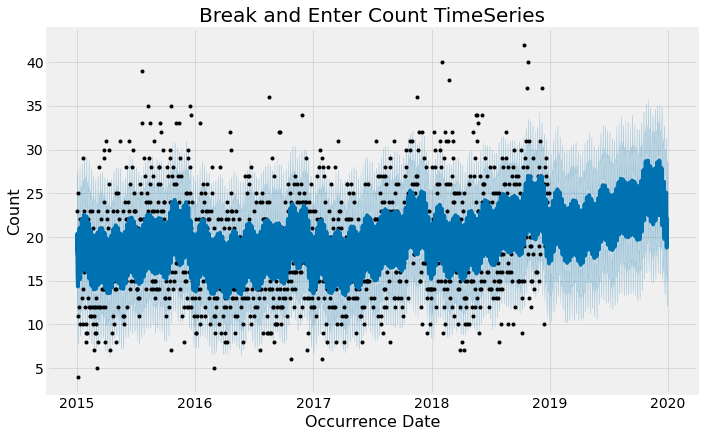

In [ ]:
breakAndEnterTimewiseData= df[df.MCI == 'Break and Enter'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
breakAndEnterTimewiseData= breakAndEnterTimewiseData[breakAndEnterTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  breakAndEnterTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

breakAndEnterProphetModel= Prophet(daily_seasonality=True).fit(breakAndEnterTimewiseData[breakAndEnterTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
breakAndEnterProphetForecast= breakAndEnterProphetModel.make_future_dataframe(periods=365)
breakAndEnterProphetForecast= breakAndEnterProphetModel.predict(breakAndEnterProphetForecast)


breakAndEnterProphetModel.plot(breakAndEnterProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Break and Enter Count TimeSeries');

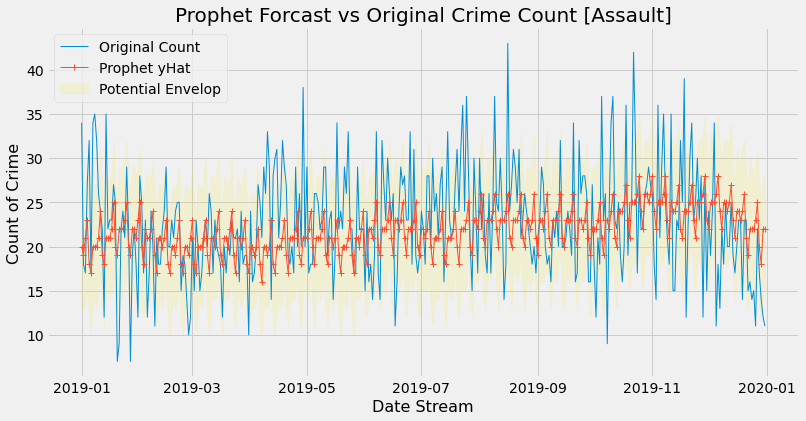

In [ ]:
comparableData= breakAndEnterTimewiseData[breakAndEnterTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= breakAndEnterProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= breakAndEnterProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= breakAndEnterProphetForecast['yhat_upper'].astype('int')


mciDifferedResult['BreakAndEnter']= comparableData.yhat
mciDifferedResult['lower']= mciDifferedResult['lower'] + comparableData.yhatLower
mciDifferedResult['upper']= mciDifferedResult['upper'] + comparableData.yhatUpper


plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

### Robbery
> Major MCI **Robbery** Data Extraction

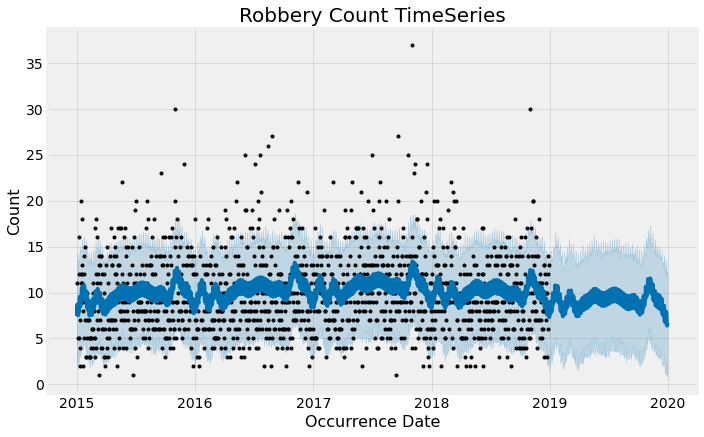

In [ ]:
RobberyTimewiseData= df[df.MCI == 'Robbery'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
RobberyTimewiseData= RobberyTimewiseData[RobberyTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  RobberyTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

RobberyProphetModel= Prophet(daily_seasonality=True).fit(RobberyTimewiseData[RobberyTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
RobberyProphetForecast= RobberyProphetModel.make_future_dataframe(periods=365)
RobberyProphetForecast= RobberyProphetModel.predict(RobberyProphetForecast)


RobberyProphetModel.plot(RobberyProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Robbery Count TimeSeries');

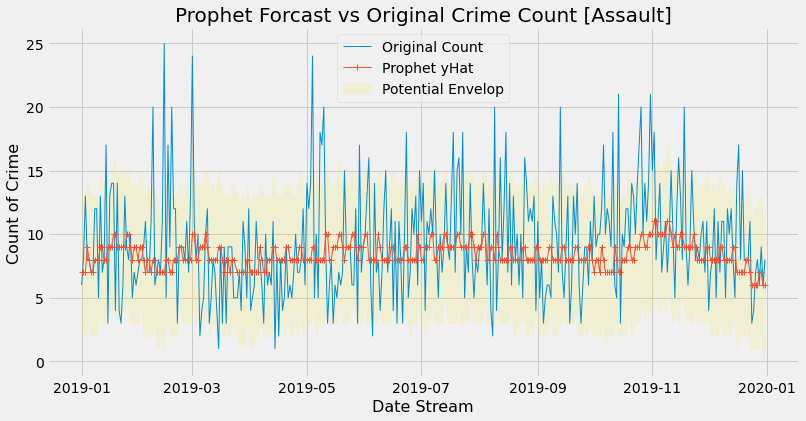

In [ ]:
comparableData= RobberyTimewiseData[RobberyTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= RobberyProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= RobberyProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= RobberyProphetForecast['yhat_upper'].astype('int')



mciDifferedResult['Robbery']= comparableData.yhat
mciDifferedResult['lower']= mciDifferedResult['lower'] + comparableData.yhatLower
mciDifferedResult['upper']= mciDifferedResult['upper'] + comparableData.yhatUpper


plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

### Theft Over
> Major MCI **Theft Over** Data Extraction

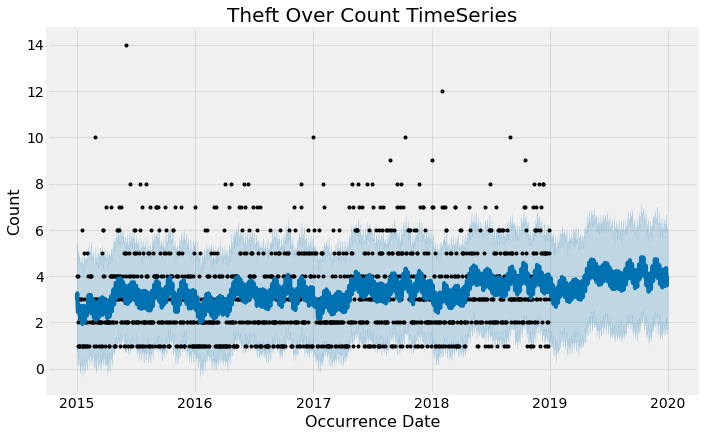

In [ ]:
theftOverTimewiseData= df[df.MCI == 'Theft Over'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
theftOverTimewiseData= theftOverTimewiseData[theftOverTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  theftOverTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

theftOverProphetModel= Prophet(daily_seasonality=True).fit(theftOverTimewiseData[theftOverTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
theftOverProphetForecast= theftOverProphetModel.make_future_dataframe(periods=365)
theftOverProphetForecast= theftOverProphetModel.predict(theftOverProphetForecast)


theftOverProphetModel.plot(theftOverProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Theft Over Count TimeSeries');

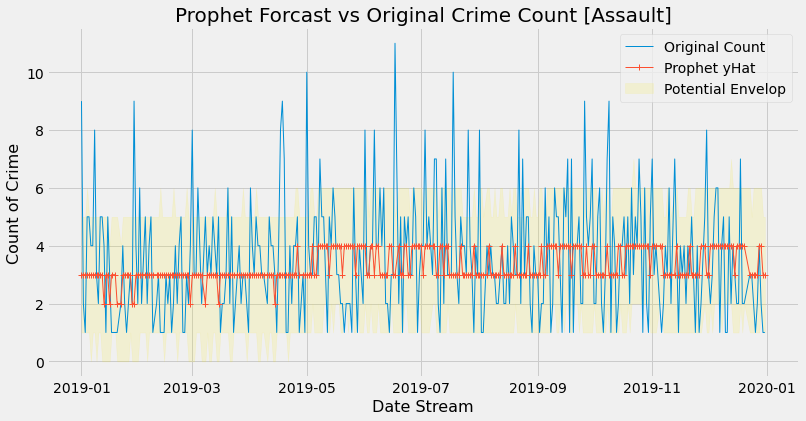

In [ ]:
comparableData= theftOverTimewiseData[theftOverTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= theftOverProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= theftOverProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= theftOverProphetForecast['yhat_upper'].astype('int')



mciDifferedResult['TheftOver']= comparableData.yhat
mciDifferedResult['lower']= mciDifferedResult['lower'] + comparableData.yhatLower
mciDifferedResult['upper']= mciDifferedResult['upper'] + comparableData.yhatUpper


plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

## **Discrete Approach** vs **Complete Count** Approach Comparison

In [ ]:
# mciDifferedResult= mciDifferedResult.iloc[1:]
# mciDifferedResult['ds']= prophetForcast_yhat.index
mciDifferedResult.set_index('ds', inplace=True)
calcMciComp= mciDifferedResult.iloc[:150]
calcMciComp['MCIsum']= calcMciComp.loc[:, ['Assault', 'AutoTheft', 'BreakAndEnter', 'Robbery', 'TheftOver']].sum(axis=1)

In [ ]:
mse= round(((calcMciComp['MCIsum'] - testData['count'].iloc[:150])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((testData['count'].iloc[:150] - calcMciComp['upper'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((testData['count'].iloc[:150] - calcMciComp['lower'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Divided Sum vs Original Count Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))

Prophet Divided Sum vs Original Count Error Analysis

Mean Square Error: 286.75
Root Mean Square Error: 16.93
Mean Square Error with Upper Envelop: 1402.39
Root Mean Square Error with Upper Envelop: 37.45
Mean Square Error with Lower Envelop: 1580.37
Root Mean Square Error with Lower Envelop: 39.75


In [ ]:
mse= round(((calcMciComp['MCIsum'] - prophetForcast_yhat.yhat.iloc[:150])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'].iloc[:150] - calcMciComp['upper'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'].iloc[:150] - calcMciComp['lower'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Complete Data vs Prophet Divided Sum Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))

Prophet Complete Data vs Prophet Divided Sum Error Analysis

Mean Square Error: 12.11
Root Mean Square Error: 3.48
Mean Square Error with Upper Envelop: 199.43
Root Mean Square Error with Upper Envelop: 14.12
Mean Square Error with Lower Envelop: 277.71
Root Mean Square Error with Lower Envelop: 16.66


# **Classification** Problem and Data Label Prediction Analysis

In [ ]:
plt.style.use('seaborn-whitegrid')

In [ ]:
classificationSet= df.loc[:, ['premisetype', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear', 'reportedmonth', 'reportedday', 'reporteddayofyear', 'reporteddayofweek', 
                              'reportedhour', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI', 
                              'Division', 'Hood_ID', 'delayInReporting']]
classificationSet.head()

premisetype  ucr_code  ucr_ext  ... Division  Hood_ID delayInReporting
0  Commercial      1430      100  ...      D14       79                0
1  Commercial      1430      100  ...      D42      118                2
2   Apartment      2120      200  ...      D43      137                2
3       Other      2120      200  ...      D43      133               22
4  Commercial      1430      100  ...      D55       61                0

[5 rows x 20 columns]

#### Conversion of String Column to **Categorical Column**

In [ ]:
classificationSet['premisetypeCat']= classificationSet.premisetype.astype('category').cat.codes
classificationSet['offenceCat']= classificationSet.offence.astype('category').cat.codes
classificationSet['reportedmonthCat']= classificationSet.reportedmonth.astype('category').cat.codes
classificationSet['reporteddayofweekCat']= classificationSet.reporteddayofweek.astype('category').cat.codes
classificationSet['occurrencemonthCat']= classificationSet.occurrencemonth.astype('category').cat.codes
classificationSet['occurrenceyear']= classificationSet.occurrenceyear.fillna(method='ffill').astype('int')
classificationSet['occurrenceday']= classificationSet.occurrenceday.fillna(method='ffill').astype('int')
classificationSet['occurrencedayofyear']= classificationSet.occurrencedayofyear.fillna(method='ffill').astype('int')
classificationSet['occurrencedayofweekCat']= classificationSet.occurrencedayofweek.astype('category').cat.codes
classificationSet['mciCat']= classificationSet.MCI.astype('category').cat.codes
classificationSet['division']= (classificationSet.Division.str)[1:]

In [ ]:
classicicationNumaric= classificationSet.loc[:, ['ucr_code', 'ucr_ext', 'reportedyear', 'reportedday', 'reporteddayofyear', 'reportedhour', 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear', 'occurrencehour', 
                          'Hood_ID', 'delayInReporting', 'premisetypeCat', 'offenceCat', 'reportedmonthCat', 'reporteddayofweekCat', 'occurrencemonthCat', 'occurrencedayofweekCat', 'mciCat', 'division']]

#### Removal of **Highly Correlated** Columns

[]

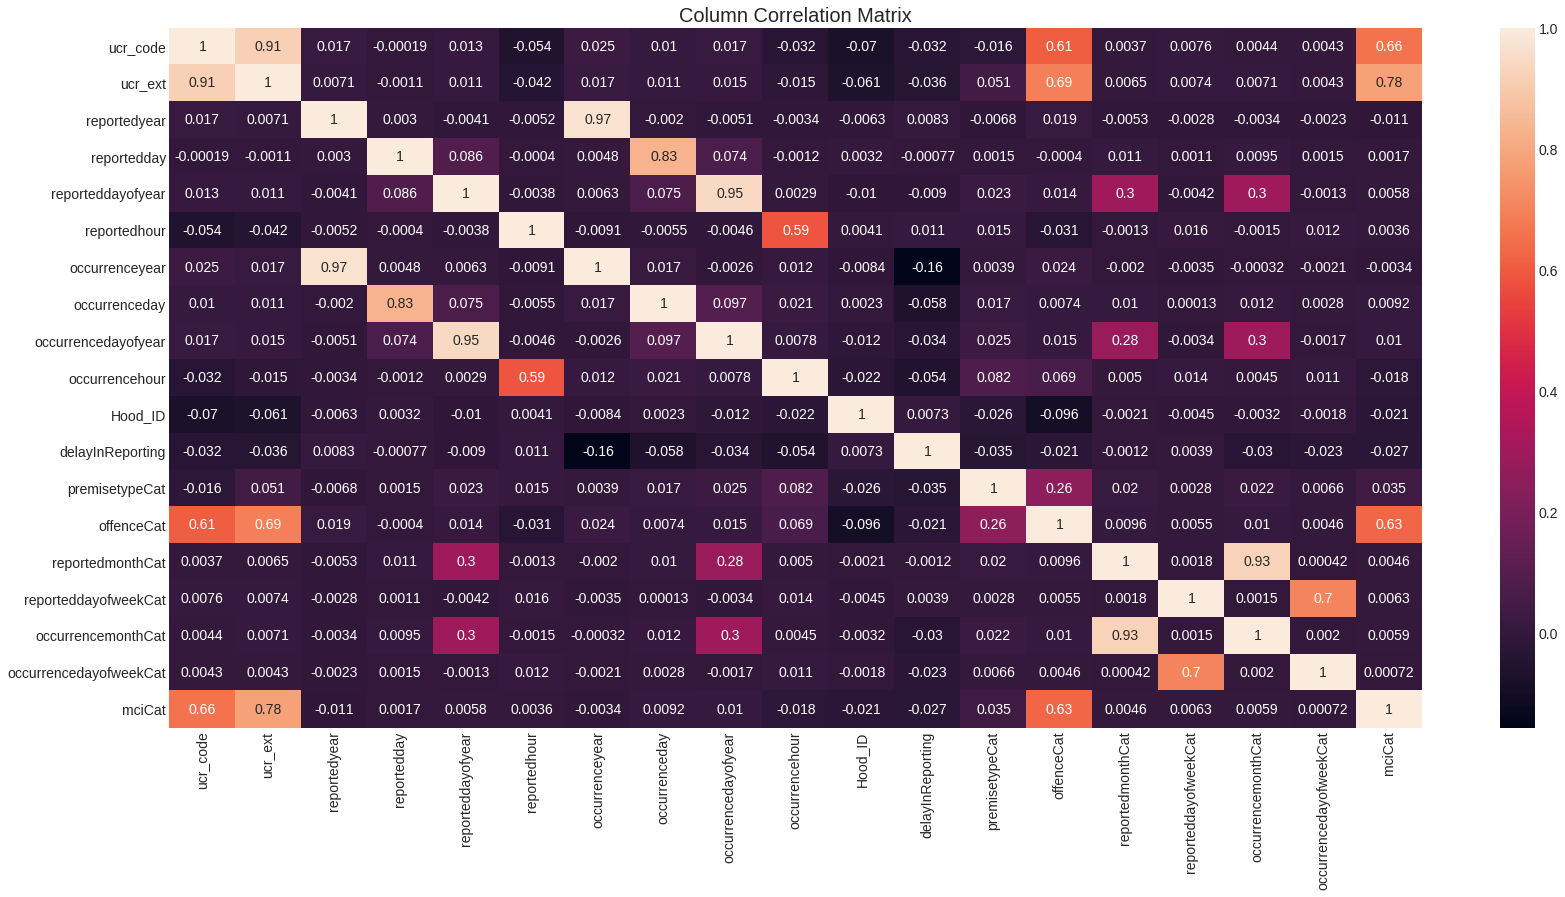

In [ ]:
corrMatrix= classicicationNumaric.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(corrMatrix, annot=True)
plt.title('Column Correlation Matrix')
plt.plot()

In [ ]:
classicicationNumaric.drop(labels=['ucr_ext', 'reportedyear', 'reporteddayofyear', 'reportedmonthCat'], axis=1, inplace=True)

#### Label Split [X, y Division] for **MCI Prediction**

In [ ]:
MCI_y= classicicationNumaric['mciCat']
MCI_X= classicicationNumaric.drop(['mciCat', 'offenceCat'], axis=1)

#### Feature Engineering

In [ ]:
MCI_X.columns

Index(['ucr_code', 'reportedday', 'reportedhour', 'occurrenceyear',
       'occurrenceday', 'occurrencedayofyear', 'occurrencehour', 'Hood_ID',
       'delayInReporting', 'premisetypeCat', 'offenceCat',
       'reporteddayofweekCat', 'occurrencemonthCat', 'occurrencedayofweekCat',
       'division'],
      dtype='object')

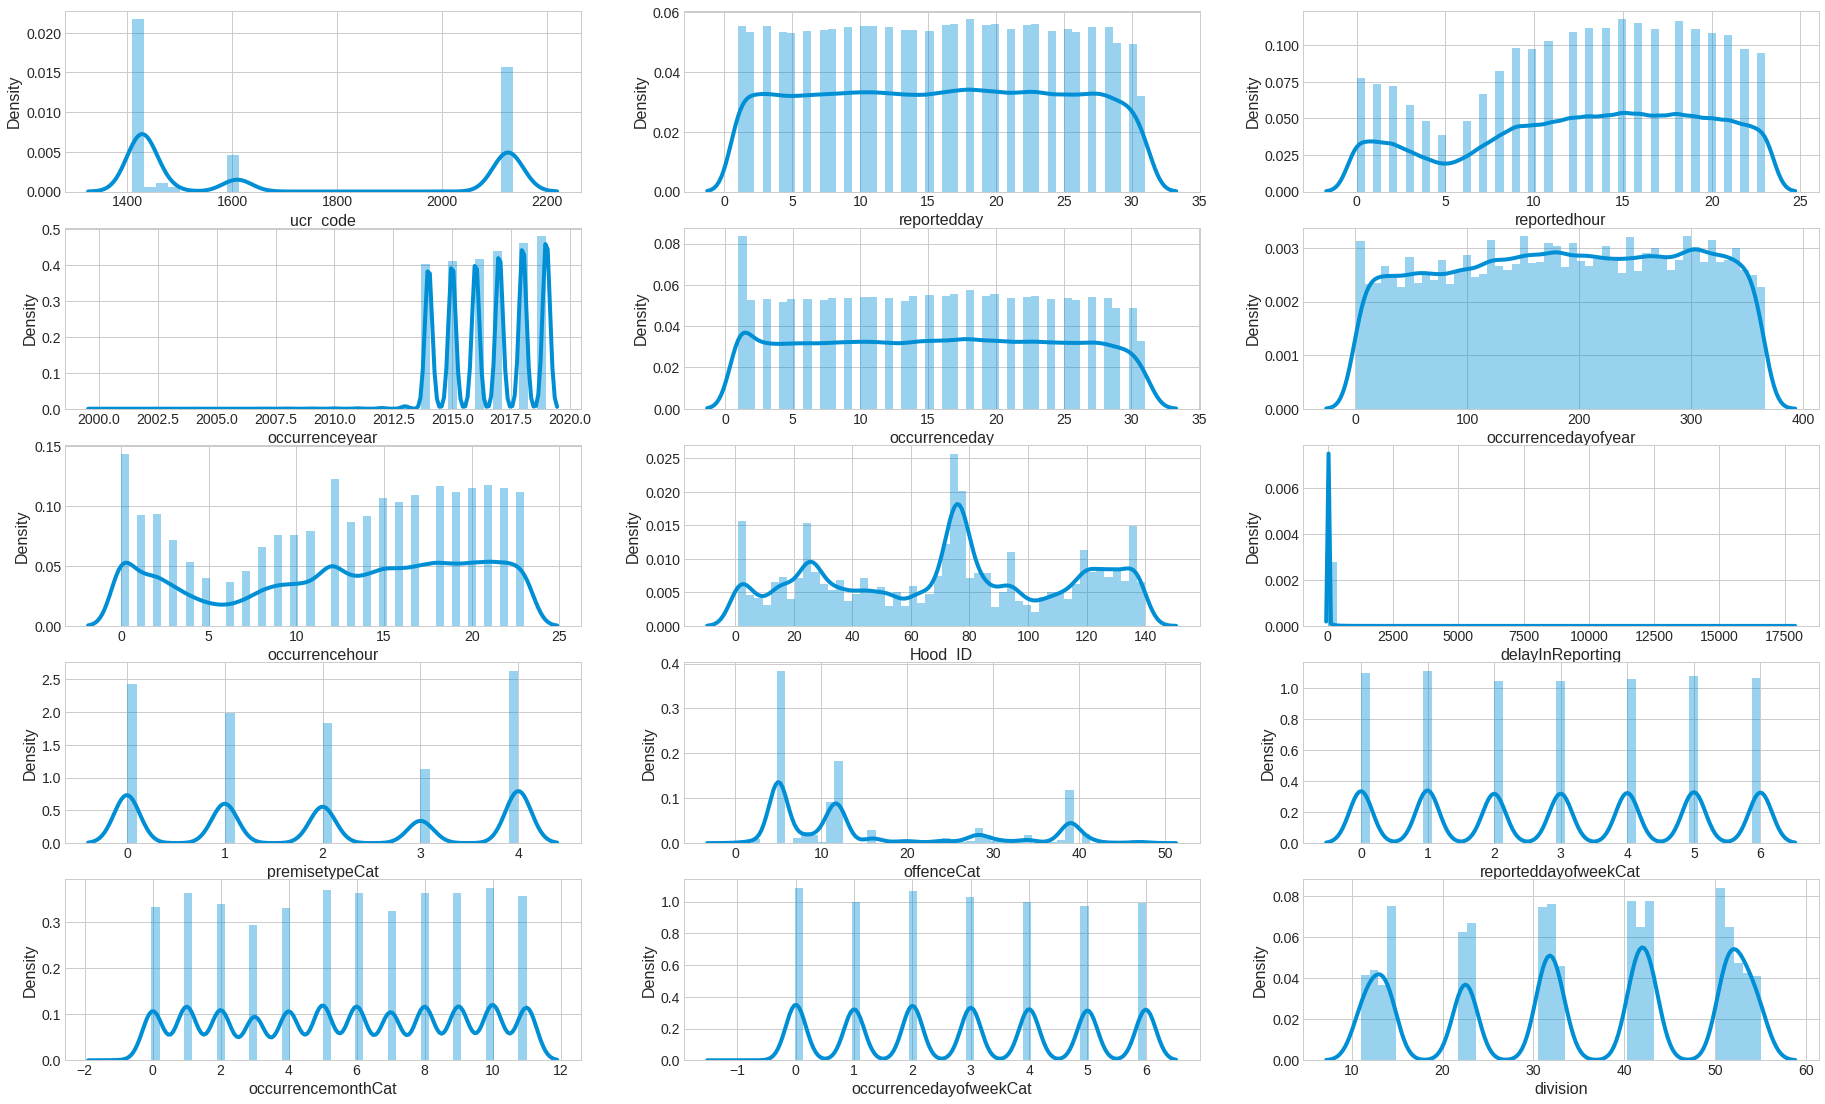

In [ ]:
plt.figure(figsize=(28, 18))

for i, _ in enumerate(MCI_X.columns):  
  plt.subplot(5,3,i+1)
  sns.distplot(MCI_X[_])

plt.show()

In [ ]:
RFE_RandomForestWeight= []
RFE_Index= []
for i in tqdm(range(100, 1100, 100)):
  recursiveFeatureEleminationClassifier= RandomForestClassifier(n_estimators=i)
  recursiveFeatureEleminationClassifier.fit(MCI_X, MCI_y)
  RFE_RandomForestWeight.append(recursiveFeatureEleminationClassifier.feature_importances_)
  RFE_Index.append('nEst {}'.format(i))

REF_DataFrame= pd.DataFrame(RFE_RandomForestWeight, columns=MCI_X.columns)
REF_DataFrame['nEst']= RFE_Index
REF_DataFrame.set_index('nEst', inplace=True)

100%|██████████| 10/10 [16:22<00:00, 98.27s/it] 


In [ ]:
REF_DataFrame

ucr_code  reportedday  ...  occurrencedayofweekCat  division
nEst                              ...                                  
nEst 100   0.801032     0.006114  ...                0.003808  0.008038
nEst 200   0.805555     0.005700  ...                0.003606  0.007124
nEst 300   0.802332     0.005849  ...                0.003770  0.007349
nEst 400   0.797758     0.006094  ...                0.003917  0.007354
nEst 500   0.800025     0.006057  ...                0.003847  0.007460
nEst 600   0.799988     0.006073  ...                0.003887  0.007391
nEst 700   0.798770     0.006114  ...                0.004003  0.007603
nEst 800   0.801931     0.005980  ...                0.003876  0.007376
nEst 900   0.799554     0.006097  ...                0.003893  0.007392
nEst 1000  0.801437     0.005934  ...                0.003855  0.007275

[10 rows x 14 columns]